In [1]:
import pandas as pd

from src.io_utils import load_data, coerce_numeric

df = coerce_numeric(load_data("data/library_loans.csv"))
df = df.dropna(subset=["loan_days"]).copy()
df = df[df["loan_days"] > 0].copy()

df["month"] = df["checkout_date"].dt.to_period("M").dt.to_timestamp()
df["week"] = df["checkout_date"].dt.to_period("W").dt.start_time

df.info()
# df.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 0 to 127
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   loan_id           124 non-null    object        
 1   checkout_date     124 non-null    datetime64[ns]
 2   branch            121 non-null    object        
 3   genre             118 non-null    object        
 4   item_type         123 non-null    object        
 5   patron_age_group  123 non-null    object        
 6   loan_days         124 non-null    int64         
 7   returned_date     108 non-null    datetime64[ns]
 8   overdue_days      114 non-null    float64       
 9   fine_amount       113 non-null    float64       
 10  month             124 non-null    datetime64[ns]
 11  week              124 non-null    datetime64[ns]
dtypes: datetime64[ns](4), float64(2), int64(1), object(5)
memory usage: 12.6+ KB


In [2]:
from src import metrics as M

print("Totalt antal lån:", M.total_loans(df))
print("Genomsnittlig lånetid (dagar):", f"{M.avg_loan_days(df):.1f}")
print("Andel övertid (%):", f"{100 * M.overdue_rate(df):.1f}%")

Totalt antal lån: 116
Genomsnittlig lånetid (dagar): 21.3
Andel övertid (%): 47.6%


In [3]:
by_genre = M.loans_by_genre(df)
by_branch = M.loans_by_branch(df)
by_genre, by_branch

(      genre  loans
 0  Biografi     22
 1     Fakta     22
 2   Deckare     20
 3    Sci-Fi     17
 4  Romantik     17
 5      Barn     16
 6       NaN      6,
     branch  loans
 0    Öster     32
 1   Väster     28
 2     Norr     21
 3  Centrum     20
 4    Söder     13
 5      NaN      3)

In [4]:
ts_month = M.loans_over_time(df, freq="M")
ts_month.head()

c:\Users\joaki\Desktop\python\src\metrics.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(freq)["loan_id"]


checkout_date  loans
0    2025-01-31     16
1    2025-02-28     15
2    2025-03-31      9
3    2025-04-30      9
4    2025-05-31     13

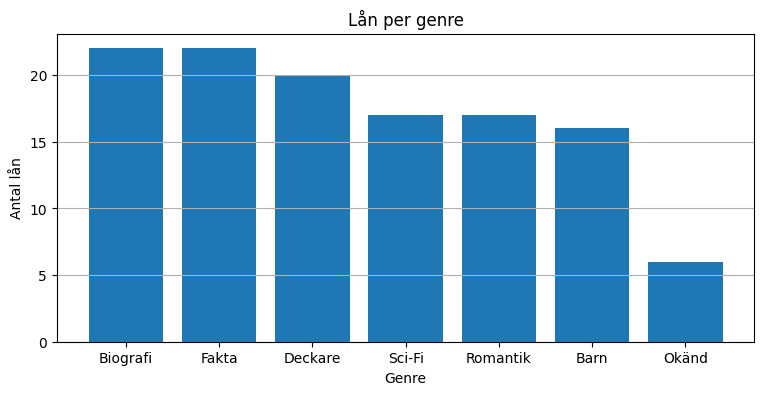

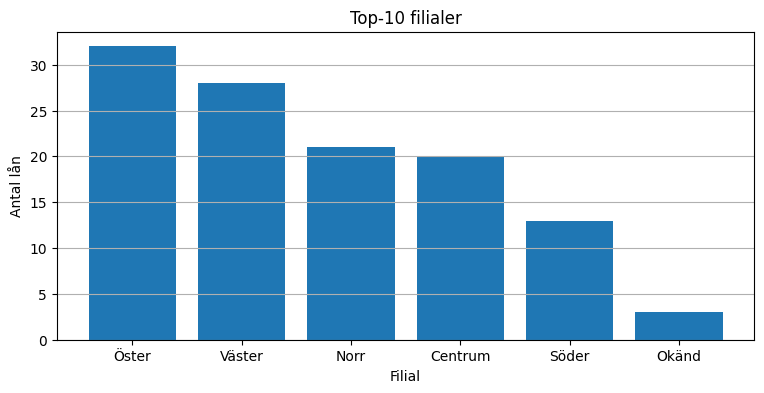

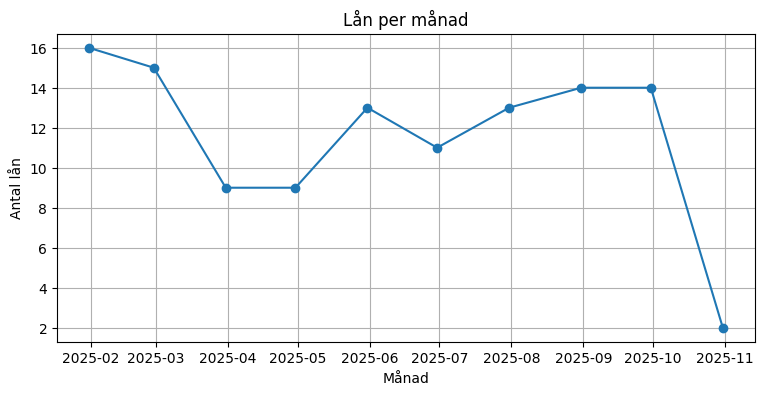

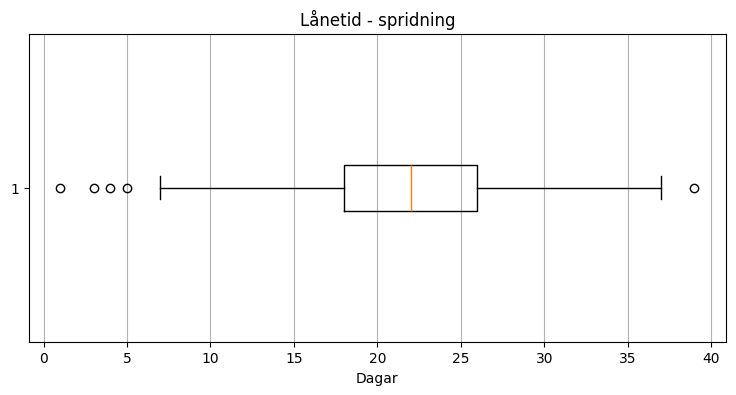

In [9]:
import matplotlib.pyplot as plt
from src import viz as V

# Lån per genre
fig, ax = plt.subplots(figsize=(9, 4))
V.bar(ax, by_genre["genre"], by_genre["loans"], "Lån per genre", "Genre", "Antal lån")
plt.savefig("images/fig_loans_by_genre.png", dpi=200)

# Top-10 filialer
fig, ax = plt.subplots(figsize=(9, 4))
top_10 = by_branch.head(10)
V.bar(ax, top_10["branch"], top_10["loans"], "Top-10 filialer", "Filial", "Antal lån")
plt.savefig("images/fig_top10_branches.png", dpi=200)

# Lån per månad
fig, ax = plt.subplots(figsize=(9, 4))
V.line(ax, ts_month["checkout_date"], ts_month["loans"], "Lån per månad", "Månad", "Antal lån")
plt.savefig("images/fig_loans_over_months.png", dpi=200)

# Spridning av lånetid
fig, ax = plt.subplots(figsize=(9, 4))
V.box_h(ax, df["loan_days"], "Lånetid - spridning", "Dagar")
plt.savefig("images/fig_loan_days_box.png", dpi=200)

In [10]:
piv = pd.pivot_table(
    df,
    index="branch",
    columns="genre",
    values="loan_id",
    aggfunc="nunique",
    fill_value=0,
    margins=True
)

piv.to_csv("data/pivot_branch_x_genre.csv")
piv.head()

genre    Barn  Biografi  Deckare  Fakta  Romantik  Sci-Fi  All
branch                                                        
Centrum     3         3        3      3         2       4   17
Norr        4         5        3      5         2       3   21
Söder       2         3        3      2         2       1   13
Väster      6         4        4      8         6       1   28
Öster       1         7        6      4         5       7   30

In [7]:
M.top3_genres(df), M.top3_branches(df)

(      genre  loans
 0  Biografi     22
 1     Fakta     22
 2   Deckare     20,
    branch  loans
 0   Öster     32
 1  Väster     28
 2    Norr     21)

## Rekommendationer:
- Stärk inköp i Biografi och Fakta - Hög efterfrågan i flera filialer.
- Bemanna exta i Öster under månader med toppar.
- Följ upp övertidsandelen (nu 47.6%): förbättra påminnelser.